# Ciencia de datos (CC408) - Primavera 2024

## Trabajo Práctico 1 - Parte 2

### Reglas de formato y presentation
- El trabajo debe tener una extensión máxima de 8 páginas (no se permite Apéndice). Se espera una buena redacción en la resolución del práctico.
- El informe debe ser entregado en formato PDF, con los gráficos e imágenes en este mismo archivo.
- Entregar el código con los comandos utilizados, identificando claramente a qué inciso corresponde cada comando.

### Fecha de entrega:
Miércoles 2 de octubre a las 23:59 hs.

### Modalidad de entrega
- Al finalizar el trabajo práctico deben hacer un último <i>commit</i> en su repositorio de GitHub llamado “Entrega final del tp”. 
- Asegurense de haber creado una carpeta llamada TP1. Este Jupyter Notebook y el correspondiente al TP1 - Parte 2 deben estar dentro de esa carpeta.
- También deben enviar el link de su repositorio -para que pueda ser clonado y corregido- al siguiente email: ispiousas@udesa.edu.ar
- La última versión en el repositorio es la que será evaluada. Por lo que es importante que: 
    - No envien el correo hasta no haber terminado y estar seguros de que han hecho el <i>commit y push</i> a la versión final que quieren entregar. Debido a que se pueden tomar hasta 3 días de extensión a lo largo del curso, no se corregirán sus tareas hasta no recibir el correo.
    - No hagan nuevos <i>push</i> despues de haber entregado su versión final. Esto generaría confusión acerca de que versión es la que quieren que se les corrija. 

### Parte I: Limpieza de la base

#### Ejercicio 1
La base de datos provista contiene información sobre oferentes de Airbnb en la ciudad de Nueva York. Realicen una limpieza de la base.
- Tengan en cuenta si hay valores duplicados y eliminénlos.
- Eliminen las columnas que no tienen información de interés.
- (Opcional) Luego de leer el artículo __[Missing-data imputation](https://bookdown.org/mike/data_analysis/imputation-missing-data.html##imputation-missing-data)__ (__[Missing-data imputation articulo alternativo](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)__), decidan qué hacer con los missing values e implementen su decision. Justifiquen su eleccion. Pueden usar informacion del paper mencionado o de otras fuentes (citenlas si las usan) para explicar los problemas que pueden surgir por su estrategia elegida.
- Si hay observaciones con *outliers* o valores que no tienen sentido, tomen una decision. Expliquen las decisiones tomadas.
- Transformen las variables **‘neighbourhood_group’** y **‘room_type’** a variables numericas.
- Con la ayuda de los comandos <code>groupby</code> y <code>join</code> o <code>merge</code>, creen una columna que tenga la cantidad de oferentes por “Neighbourhood group”. Llamen a esa nueva columna <code>offer group</code>

In [345]:
# Importamos las librerías a usar 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## 0. LECTURA DEL DOCUMENTO
df_airbnb = pd.read_csv("C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 2/Base Airbnb NY.csv")

#Dirección de Maggie: "C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 2/Base Airbnb NY.csv"
#Dirección de Peter: "c:/Users/SAMSUNG/Documents/Udesa Primavera 2024/Ciencia de datos/TP2/Base Airbnb NY.csv"

In [331]:
##1. LIMPIEZA BÁSICA

  # Se eliminan las columnas que no son relevantes
columns_drop = ['name','host_id','host_name','id'] 
df_airbnb = df_airbnb.drop(columns=columns_drop)

  # Se eliminan duplicados
duplicates = df_airbnb[df_airbnb.duplicated()]
print("Number of duplicate rows:", len(duplicates))
if len(duplicates) > 0:
  df_airbnb = df_airbnb.drop_duplicates() 
  print("Duplicate rows removed.")
else:
  print("No duplicate rows found.")

#Se eliminan las filas cuyo price tengan valor 0
df_airbnb = df_airbnb[df_airbnb['price'] != 0]

## 2. SE AGREGAN COLUMNAS 
# Columnas agregadas
# - Last_review_days
# - Dummy por cada neigbourhood
# - Dummy por cada Room
# - Offer Group

    #Last review a numero (distancia de la fecha al presente)
df_airbnb['last_review'] = pd.to_datetime(df_airbnb['last_review']) #Se tranforma a objeto
present = pd.to_datetime('today') #Se calcula la fecha presente
df_airbnb['last_review_days'] = (present - df_airbnb['last_review']).dt.days ## Se resta la fecha al presente

    #Transformación de las variables ‘neighbourhood_group’ y ‘room_type’ a variables numéricas.
dummy_neighbourhood = pd.get_dummies(df_airbnb['neighbourhood_group'], prefix='neighbourhood')
for column in dummy_neighbourhood.columns:
    dummy_neighbourhood[column] = dummy_neighbourhood[column].map(lambda x: 1 if x else 0)

dummy_room = pd.get_dummies(df_airbnb['room_type'], prefix='room')
for column in dummy_room.columns:
    dummy_room[column] = dummy_room[column].map(lambda x: 1 if x else 0)

df= pd.concat([df_airbnb, dummy_neighbourhood, dummy_room], axis=1)


    # Con la ayuda de los comandos groupby y join o merge, creen una columna que tenga la cantidad de oferentes por “Neighbourhood group”. Llamen a esa nueva columna offer group#
offer_count = df.groupby('neighbourhood_group')['neighbourhood_group'].count().reset_index(name='offer_group')
df = pd.merge(df, offer_count, on='neighbourhood_group', how='left')

    # Pone un 0 en review_per_month cuando numbes_of_reviews es 0
df.loc[df['number_of_reviews'] == 0, 'reviews_per_month'] = 0

    # Creo DF base sin las categóricas
drop_columns = ['neighbourhood_group','neighbourhood','room_type','last_review']
df_numbers = df.drop (columns =drop_columns)

### 3. DIAGNÓSTICO MISSING VALUES E IMPUTACIÓN

# Visual de Missing Data
# !pip install missingno
# import missingno as msno
# msno.matrix(df_airbnb)
# msno.heatmap(df_airbnb)

### 4. ELIMINACIÓN E IMPUTACIÓN DE DATOS

  # Elimino los datos de price y availability
df.dropna(subset=['price', 'availability_365'],how='any',inplace=True)

  # MAR: Advanced predictive modeling techniques like regression, MICE, or machine learning.
mice_imputer = IterativeImputer()
df['reviews_per_month'] = mice_imputer.fit_transform(df[['reviews_per_month']])
df['last_review_days'] = mice_imputer.fit_transform(df[['last_review_days']])

## 5. DF BASE Y TRANSFORMADA
#- df    (es el original)
#- df_trans     (es el tranformado con log)}
#- df_numbers   (no tiene variables con string)

# transformación de las columnas con log
df_trans = df.copy()
lista_columnas_transformar = [
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']
for columna in lista_columnas_transformar:
  df_trans[columna] = df_trans[columna].replace(0,1)
  df_trans[columna] = np.log(df_trans[columna])
df_trans.dropna(subset=['availability_365'],how='any',inplace=True) # vuelvo a eliminar 15 datos porque hubo un error en la transformación

### 5. OUTLIERS

# DIAGNÓSTICO DE OUTLIERS
# Calculamos los cuartiles inferiores y superiores para identificar outliers
q_outliers = 0
for column in df_trans.select_dtypes(include=np.number):
  Q1 = df_trans[column].quantile(0.25)
  Q3 = df_trans[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df_trans[(df_trans[column] < lower_bound) | (df_trans[column] > upper_bound)]

  if len(outliers) > 0:
    print(f"Outliers en columna '{column}':", len(outliers))
    q_outliers = q_outliers + len(outliers)
print ("Total de outliers: ", q_outliers)

#### Sacamos los outliers de precio
columnas_outliers = ['price']
for column in columnas_outliers:
  Q1 = df_trans[column].quantile(0.25)
  Q3 = df_trans[column].quantile(0.75)
  IQR = Q3 - Q1

  Q1_2 = df[column].quantile(0.25)
  Q3_2= df[column].quantile(0.75)
  IQR_2 = Q3_2 - Q1_2

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  lower_bound_2 = Q1_2 - 1.5 * IQR_2
  upper_bound_2 = Q3_2 + 1.5 * IQR_2

###Armamos dos bases filtradas (sin outliers): una para la base transformada a logaritmo y otra para la base sin transformar
df_filteredtrans = df_trans[(df_trans[column] >= lower_bound) & (df_trans[column] <= upper_bound)]
df_filtered = df[(df[column] >= lower_bound_2) & (df[column] <= upper_bound_2)]

Number of duplicate rows: 10
Duplicate rows removed.
Outliers en columna 'latitude': 423
Outliers en columna 'longitude': 2830
Outliers en columna 'price': 626
Outliers en columna 'minimum_nights': 447
Outliers en columna 'reviews_per_month': 963
Outliers en columna 'calculated_host_listings_count': 4789
Outliers en columna 'last_review_days': 6399
Outliers en columna 'neighbourhood_Bronx': 1087
Outliers en columna 'neighbourhood_Queens': 5660
Outliers en columna 'neighbourhood_Staten Island': 373
Outliers en columna 'room_Shared room': 1158
Outliers en columna 'offer_group': 7120
Total de outliers:  31875


c:\Users\magda\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log



### Parte II: Graficos y visualizaciones

#### Ejercicio 2
Una vez hecha la limpieza, realicen una matriz de correlación con las siguientes variables:**‘neighbourhood group’, ‘latitude’, ‘longitude’, ‘room type’,‘price’, ‘minimum nights’, ‘number of reviews’, ‘reviews per month’,‘calculated host listings count’, ‘availability 365’.** Comenten los resultados. Utilicen alguno de los comandos disponibles en este link para graficar la matriz de correlacion.

*Nota:* consideren cómo es conveniente incluir las variables que originalmente eran categóricas para poder interpretar mejor la matriz de correlación.

Text(0.5, 1.0, 'Correlación de variables con "Price"')

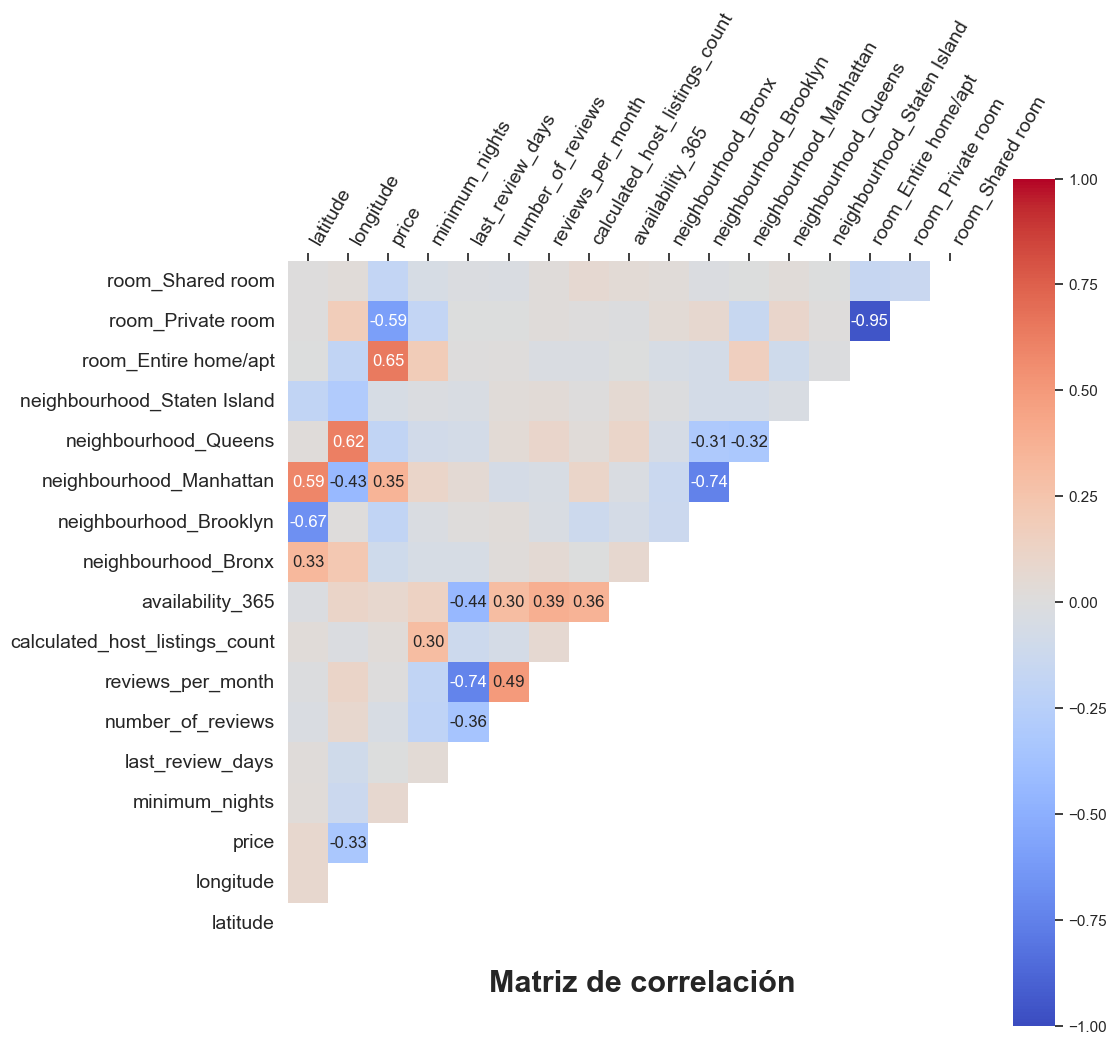

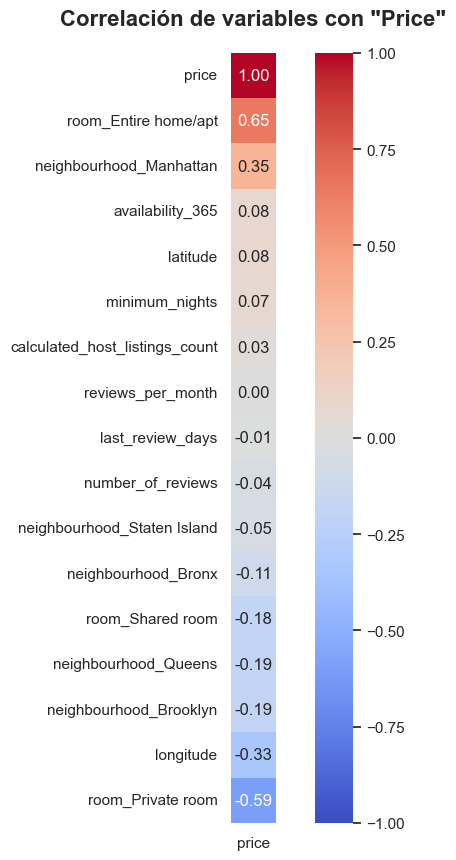

In [333]:
# Resolver acá
#Se definen las columnas a correlacionar
columnas = df_filteredtrans[['latitude', 'longitude', 'price', 'minimum_nights', 'last_review_days', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', "neighbourhood_Bronx","neighbourhood_Brooklyn","neighbourhood_Manhattan",	"neighbourhood_Queens",	"neighbourhood_Staten Island",	"room_Entire home/apt",	"room_Private room"	, "room_Shared room"	 ]]

#Matriz de correlación
correlacion = columnas.corr()
mask = np.zeros_like(correlacion)
mask[np.triu_indices_from(mask)] = True

annot_labels = np.empty(correlacion.shape, dtype=object) 
for i in range(correlacion.shape[0]):
    for j in range(correlacion.shape[1]):
        if abs(correlacion.iloc[i, j]) > 0.3:  
            annot_labels[i, j] = f"{correlacion.iloc[i, j]:.2f}" 
        else:
            annot_labels[i, j] = '' 

plt.figure(figsize=(11,11), facecolor='white')

sns.heatmap(correlacion, vmax=1, vmin=-1, square=True, annot=annot_labels, fmt="", cmap='coolwarm', mask = mask, linewidths=0, linecolor='white')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

plt.gca().invert_yaxis()  
plt.gca().xaxis.tick_top()
plt.xticks(rotation=60, ha='left', fontsize=14)
plt.yticks(fontsize=14)
plt.text(5, -1, 'Matriz de correlación', fontsize=22, va='center', weight = "bold")


#Otro gráfico que solo muestra las correlaciones con price
plt.figure(figsize=(10,10))
sns.heatmap(correlacion[["price"]].sort_values(by=["price"], ascending=False), vmax=1, vmin=-1, square=True, annot= True, fmt='.2f', cmap='coolwarm')

plt.title('Correlación de variables con "Price"', ha='center', weight="bold", pad=20, fontsize=16)


#### Ejercicio 3
Respondan las siguientes preguntas: ¿Cuál es la proporción de oferentes por “Neighbourhood group”? ¿Y por tipo de habitación? Además, realicen gráficos para mostrar estas composiciones y comenten los resultados.

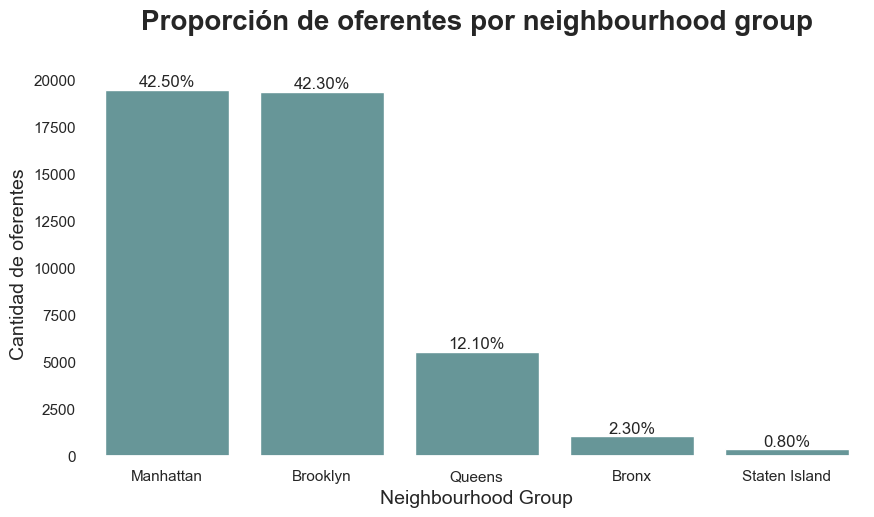

In [295]:
#Resolver acá

#Cantidad de oferentes por Neighbourhood group
oferentes_groups = df_filtered["neighbourhood_group"].value_counts()

#Proporción de oferentes por Neighbourhood group
proporciones_groups = df_filtered["neighbourhood_group"].value_counts(normalize=True).round(3)

# Gráfico de barras
plt.figure(figsize=(10, 5))
bar_plot = sns.barplot(x=oferentes_groups.index, y=oferentes_groups.values, color="cadetblue")

for index, value in enumerate(oferentes_groups.values):
   porcentaje= proporciones_groups[oferentes_groups.index[index]]*100
   bar_plot.text(index, value + 1, f'{porcentaje:.2f}%', ha='center', va='bottom')

plt.ylabel("Cantidad de oferentes", fontsize=14)
plt.title("Proporción de oferentes por neighbourhood group", fontsize=20, weight="bold", pad=30)
plt.xlabel("Neighbourhood Group", fontsize=14)
plt.show()

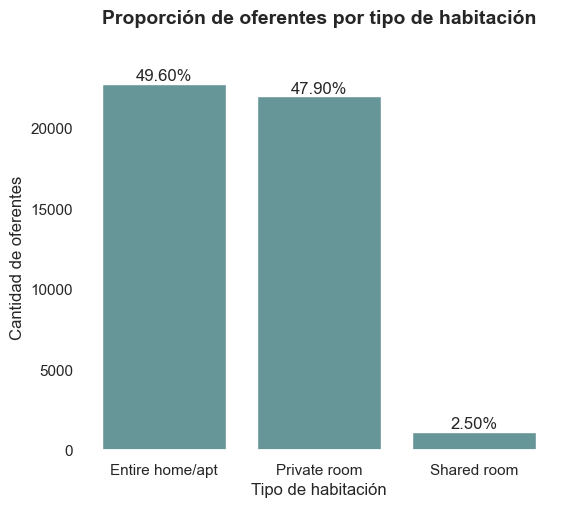

In [280]:
#Cantidad de oferentes por tipo de habitación
oferentes_rooms = df_filtered["room_type"].value_counts()

#Proporción de oferentes por tipo de habitación
proporciones_rooms = df_filtered["room_type"].value_counts(normalize=True).round(3)

# Gráfico de barras
plt.figure(figsize=(6, 5))
bar_plot = sns.barplot(x=oferentes_rooms.index, y=oferentes_rooms.values, color="cadetblue")

for index, value in enumerate(oferentes_rooms.values):
   porcentaje_r= proporciones_rooms[oferentes_rooms.index[index]]*100
   bar_plot.text(index, value + 1, f'{porcentaje_r:.2f}%', ha='center', va='bottom')

plt.ylabel("Cantidad de oferentes", fontsize=12)
plt.title("Proporción de oferentes por tipo de habitación", fontsize=14, weight="bold", pad=30)
plt.xlabel("Tipo de habitación", fontsize=12) 
plt.show()

#### Ejercicio 4
Realicen un histograma de los precios de los alojamientos. Comenten el gráfico obtenido. Además, respondan las siguientes preguntas: ¿cuál es el precio mínimo, máximo y promedio? ¿Cuál es la media de precio por “Neighbourhood group” y por tipo de habitación? 

In [334]:
#Precios mínimos, máximos y promedios 
print("Precio mínimo:" + str(min(df_filtered["price"])))
print("Precio máximo:" + str(max(df_filtered["price"])))
print("Precio promedio:" + str(df_filtered["price"].mean().round(2)))

#Precios mínimos, máximo y promedios por grupo
promedios_grupo = df_filtered.groupby('neighbourhood_group')['price'].agg(["mean", "min", "max"]).reset_index().round(2)
promedios_room = df_filtered.groupby('room_type')['price'].agg(["mean", "min", "max"]).reset_index().round(2)
print("Media de precio por neighbourhood group: \n", promedios_grupo)
print("\nMedia de precio por tipo de habitación: \n", promedios_room)

Precio mínimo:10.0
Precio máximo:334.0
Precio promedio:120.0
Media de precio por neighbourhood group: 
   neighbourhood_group    mean   min    max
0               Bronx   77.39  10.0  325.0
1            Brooklyn  105.75  10.0  333.0
2           Manhattan  145.95  10.0  334.0
3              Queens   88.92  10.0  325.0
4       Staten Island   89.24  13.0  300.0

Media de precio por tipo de habitación: 
          room_type    mean   min    max
0  Entire home/apt  162.54  10.0  334.0
1     Private room   79.04  10.0  333.0
2      Shared room   59.40  10.0  320.0


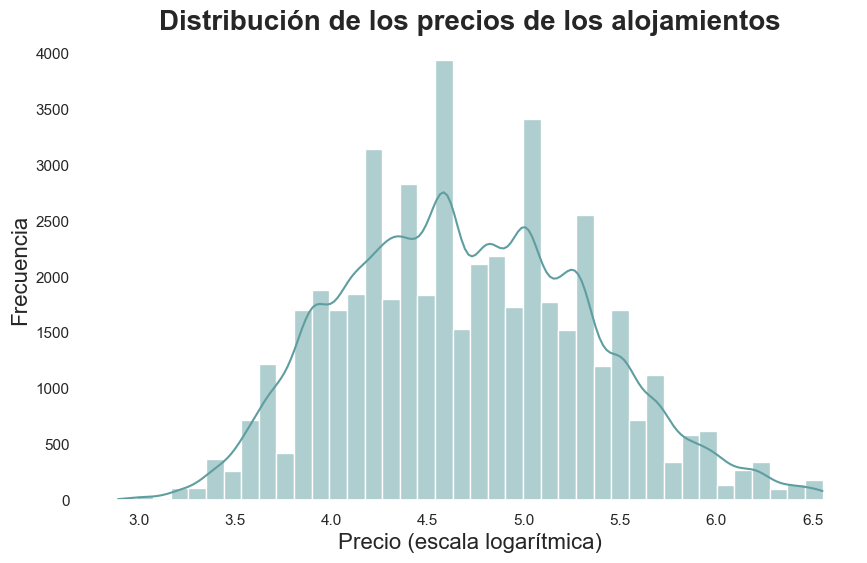

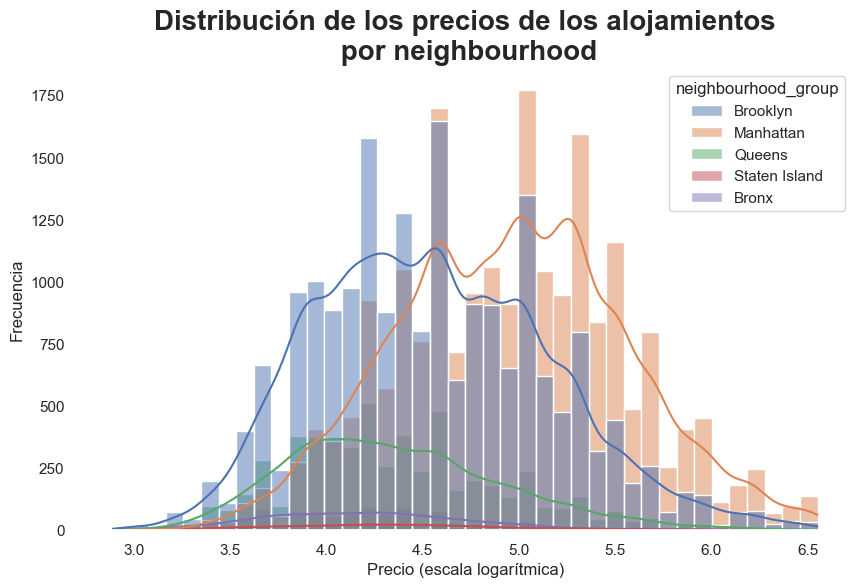

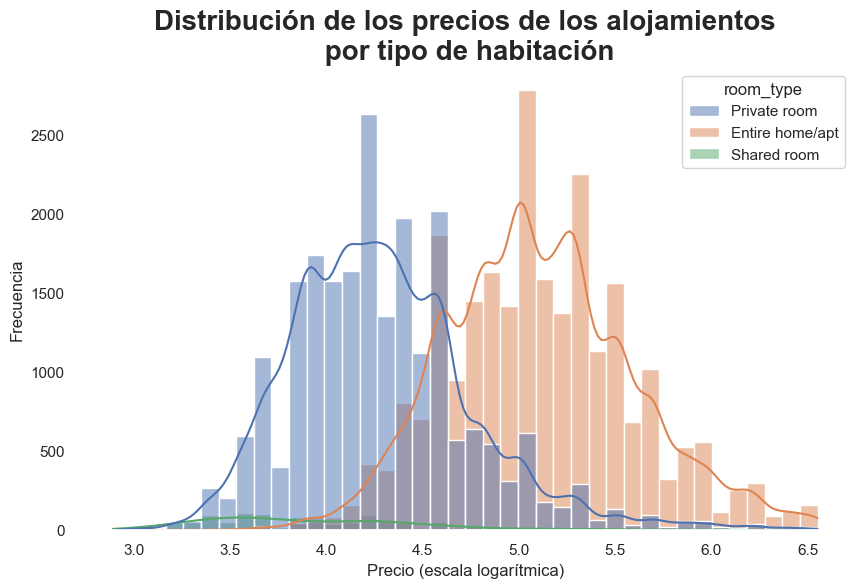

In [335]:
# Resolver acá

#Histograma de precios 
plt.figure(figsize=(10,6))
sns.histplot(data=df_filteredtrans, x='price', bins=40, color = "cadetblue", kde=True)
plt.title('Distribución de los precios de los alojamientos', fontsize=20, weight="bold")
plt.xlabel('Precio (escala logarítmica)', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)
plt.show()

#Histograma de precios por neighbourhood group
plt.figure(figsize=(10,6))
sns.histplot(data=df_filteredtrans, x='price', bins=40, color = "cadetblue", kde=True, hue= "neighbourhood_group")
plt.title('Distribución de los precios de los alojamientos\n por neighbourhood',fontsize=20, weight="bold")
plt.xlabel('Precio (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.show()

#Histograma de precios por tipo de habitación
plt.figure(figsize=(10,6))
sns.histplot(data=df_filteredtrans, x='price', bins=40, color = "cadetblue", kde=True, hue= "room_type")
plt.title('Distribución de los precios de los alojamientos\n por tipo de habitación',fontsize=20, weight="bold")
plt.xlabel('Precio (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.show()

#### Ejercicio 5
Realicen dos scatter plots con dos variables de interés en cada uno. Comenten.

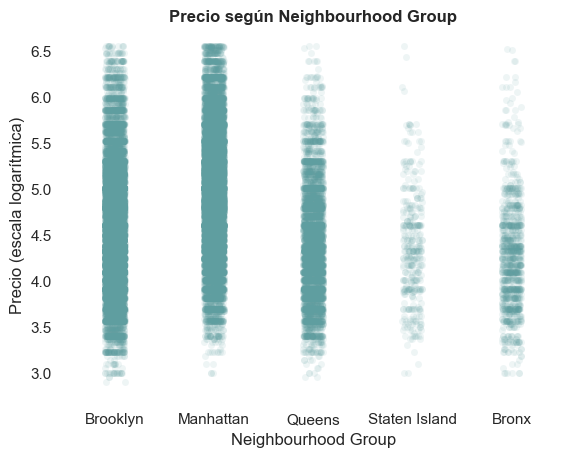

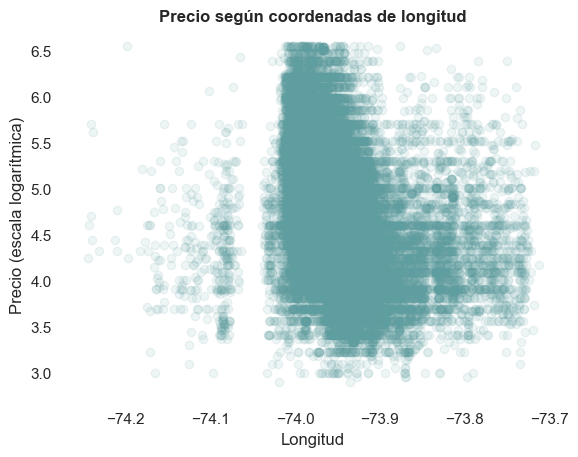

In [337]:
#Scatterplot para neighbourhood group y price
sns.stripplot(data=df_filteredtrans, x='neighbourhood_group', y ='price', alpha=0.1, color="cadetblue")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Precio (escala logarítmica)")
plt.title("Precio según Neighbourhood Group", weight="bold")
plt.show()


#Scatterplot para longitude y price
plt.scatter(data=df_filteredtrans, x="longitude", y='price', alpha=0.1, color='cadetblue')
plt.ylabel("Precio (escala logarítmica)")
plt.xlabel("Longitud")
plt.title("Precio según coordenadas de longitud", weight="bold")
plt.show()

#### Ejercicio 6
Utilicen el análisis de componentes principales para graficar las variables en dos dimensiones. Comenten los resultados obtenidos (qué porcentaje de la varianza se logra explicar con dos componentes, cómo son los *loadings*, si ven algún patrón en el gráfico).

In [339]:
# Resolver acá

#Preparamos dataframe con datos para PCA: escalados y sin variables categóricas ni numéricas
scaler = StandardScaler(with_std=True, with_mean=True) 
df_scaler = df_filteredtrans.drop(columns=["neighbourhood_group", "neighbourhood", "room_type", "offer_group", "last_review", "neighbourhood_Manhattan", "neighbourhood_Queens", "neighbourhood_Bronx", "neighbourhood_Brooklyn", "neighbourhood_Manhattan", "neighbourhood_Staten Island", "room_Entire home/apt",	"room_Private room",	'room_Shared room'])
df_scaler= pd.DataFrame(scaler.fit_transform(df_scaler), columns=df_scaler.columns)

In [340]:
#Aplicamos el PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaler)

#Varianza explicada por componente
print("Varianza explicada:", pca.explained_variance_ratio_)

#Loadings por variable
for i, loading_vector in enumerate(loading_vectors):
    print(f"\nLoading Vector CP{i+1}:")
    for j, feature in enumerate(df_scaler.columns[:-1]):
        print(f"{feature}: {round(loading_vector[j],3)}")
    print()

Varianza explicada: [0.27405809 0.17657476]

Loading Vector CP1:
latitude: 0.017
longitude: -0.144
price: 0.019
minimum_nights: 0.095
number_of_reviews: -0.421
reviews_per_month: -0.554
calculated_host_listings_count: -0.132
availability_365: -0.428


Loading Vector CP2:
latitude: 0.054
longitude: -0.305
price: 0.336
minimum_nights: 0.571
number_of_reviews: -0.205
reviews_per_month: -0.082
calculated_host_listings_count: 0.551
availability_365: 0.332



Text(0.5, 1.0, 'Análisis de componentes principales')

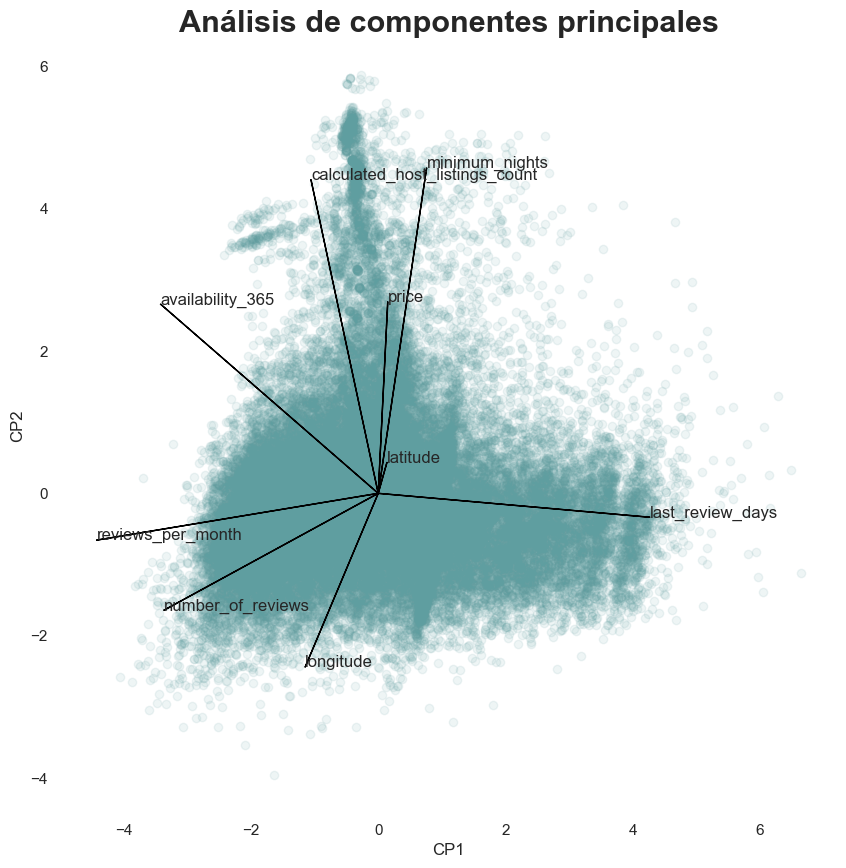

In [342]:
#Armamos dataframe de scores de cada componente para cada observacion
scores = df_pca 
pca_components = pd.DataFrame(data=df_pca, columns=['Componente_1', 'Componente_2'])
pca_components

#Gráfico de PCA con vectores 
i, j = 0, 1 # Componentes

scale_arrow = s_ = 8 
scores[:,1] *= -1
pca.components_[1] *= -1 

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(scores[:,0], scores[:,1], alpha=0.1, color="cadetblue") 
ax.set_xlabel('CP%d' % (i+1))
ax.set_ylabel('CP%d' % (j+1))
for k in range(pca.components_.shape[1]):
    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k], color="black")
    ax.text(s_*pca.components_[i,k], s_*pca.components_[j,k], df_scaler.columns[k])

plt.title("Análisis de componentes principales", fontsize=22, weight="bold")


### Parte III: Predicción

El objetivo de esta parte del trabajo es intentar predecir los precios de los alojamientos.

#### Ejercicio 7
Eliminen de la base todas las variables relacionadas al precio

In [322]:
# Resolver acá
columns_to_remove = ['minimum_nights','neighbourhood_group','neighbourhood']
df_airbnb_cleaned = df_filteredtrans.drop(columns=columns_to_remove)
print(df_airbnb_cleaned.head())

   latitude  longitude        room_type     price  number_of_reviews  \
0  40.64749  -73.97237     Private room  5.003946           2.197225   
1  40.75362  -73.98377  Entire home/apt  5.416100           3.806662   
2  40.80902  -73.94190     Private room  5.010635           0.000000   
3  40.68514  -73.95976  Entire home/apt  4.488636           5.598422   
4  40.79851  -73.94399  Entire home/apt  4.382027           2.197225   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2018-10-19          -1.560648                        1.791759   
1  2019-05-21          -0.967584                        0.693147   
2         NaT           0.000000                        0.000000   
3  2019-07-05           1.534714                        0.000000   
4  2018-11-19          -2.302585                        0.000000   

   availability_365  last_review_days  neighbourhood_Bronx  \
0          5.899897       2175.000000                    0   
1          5.872118       1961.000

#### Ejercicio 8
Partan la base en una base de prueba (test) y una de entrenamiento (train) utilizando el comando <code>train_test_split</code>. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (*random state instance*) debe ser 201. Establezca a price como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables ser´an las variables independientes (matriz X). Recuerden agregar la columna de unos (1).

In [344]:
# Resolver acá

# Definimos las variables: dependiente (y) e independientes (X)
y = df_filteredtrans['price']  
X = df_filteredtrans.drop(columns=['price','neighbourhood_group','neighbourhood','room_type','last_review'])  # Eliminamos las variables dependientes de X

# Partimos la base en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

#Agregamos columna de unos a la matriz de X
X_train = np.c_[np.ones(X_train.shape[0]), X_train]  # columna de unos al conjunto de entrenamiento
X_test = np.c_[np.ones(X_test.shape[0]), X_test]      # columna de unos al conjunto de prueba

print("Dimensiones del conjunto de entrenamiento X:", X_train.shape)
print("Dimensiones del conjunto de prueba X:", X_test.shape)
print("Dimensiones del conjunto de entrenamiento y:", y_train.shape)
print("Dimensiones del conjunto de prueba y:", y_test.shape)

Dimensiones del conjunto de entrenamiento X: (33759, 18)
Dimensiones del conjunto de prueba X: (14469, 18)
Dimensiones del conjunto de entrenamiento y: (33759,)
Dimensiones del conjunto de prueba y: (14469,)


#### Ejercicio 9
Implementen una regresión lineal y comenten los resultados obtenidos.

In [327]:
# Resolver acá
# Crear una instancia del modelo de regresión lineal
model = LinearRegression()

# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)


from sklearn.metrics import mean_squared_error, r2_score

# Calcular MSE y R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")


# Coeficientes del modelo
# coefficients = model.coef_
# feature_names = X_train.columns  

# # Crear un DataFrame para mostrar los coeficientes
# coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# print(coef_df)

Error Cuadrático Medio (MSE): 0.1901546221033128
Coeficiente de Determinación (R²): 0.5496198447212799


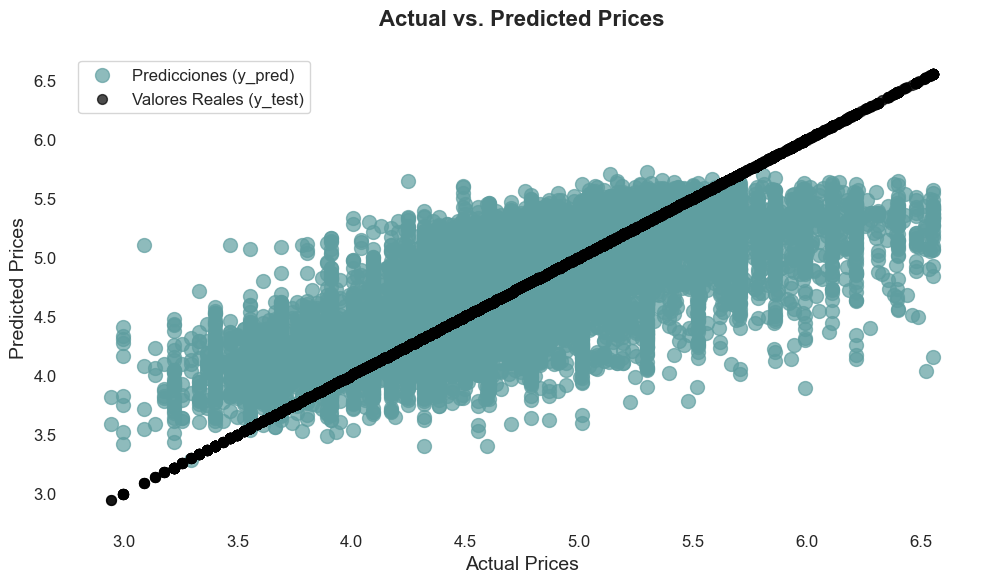

In [346]:
#Gráfico scatterplot de valores verdaderos vs predichos

plt.figure(figsize=(10, 6))  

# Graficar las predicciones
plt.scatter(y_test, y_pred, color='cadetblue', alpha=0.7, label='Predicciones (y_pred)', s=100)  
# Graficar los valores reales
plt.scatter(y_test, y_test, color='black', alpha=0.7, label='Valores Reales (y_test)', s=50)  

plt.xlabel("Actual Prices", fontsize=14)
plt.ylabel("Predicted Prices", fontsize=14)
plt.title("Actual vs. Predicted Prices", ha= 'center', weight='bold',pad=20, fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout() 
plt.show()
